# Disparities in State Voter Turnout: Culture or Policy?

Political scientists, for decades have often debated whether the low voter turnout in the USA is a question of cultural norms or voting policies. Many believe that even if we were to make voting in the United States substantially easier, we wouldn’t see large increases in turnout because the culture of voting doesn’t exist. What is often used is state by state data, where some political scientists will argue that because some states make it easier to vote, they have higher voter turnout rates (e.g. Minnesota), and the ones that don’t, see lower turnout rates (e.g. Georgia). Opponents of this theory will say that Minnesotans were always voting at a high level, and that culture of wanting to vote is what drove the policy changes, not the other way around. The way this has been traditionally studied is by grouping states into “cultural/geographic” segments, and then comparing turnout among them. 
	
Our project plan is to use data available from previous elections to test whether the differences among different states is cultural or policy oriented. We plan on doing this by constructing a data set that quantifies cultural things (i.e. demographics, geography, history of voter turnout, education rates, political participation in other forms), and using that to predict voter turnout rates. We’ll create a few training sets for regional groups, and then after training an algorithm on that, we’ll use it to compare different test sets to see if our predicted turnout rates differ from actual turnout rates. If the turnout rate of a state is predicted to be much higher than it is in reality, then one could argue that the cultural factors aren’t as important, and that there are policies in place that are preventing people from voting.

First, we import the libraries we will be using throughout the course of the project:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

C:\Users\Stephen\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here we will read in the 2009 and 2014 datasets, which will serve as the training and testing data, respectively.

In [2]:
# Read in 2009 and 2014 datasets
filename2009 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202009%20with%20turnout.csv'
filename2014 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202014%20with%20turnout.csv'
data2009 = pd.read_csv(filename2009)
data2014 = pd.read_csv(filename2014)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   fips  statcode     areaname  relig  civic  bus  pol  prof  labor  bowl  \
0  1001         1  Autauga, AL   50.0    7.0  3.0  NaN   1.0    5.0   1.0   
1  1003         1  Baldwin, AL  161.0   21.0  7.0  NaN   1.0    2.0   2.0   
2  1005         1  Barbour, AL   17.0    1.0  1.0  NaN   NaN    1.0   1.0   
3  1007         1     Bibb, AL   27.0    NaN  1.0  NaN   NaN    NaN   NaN   
4  1009         1   Blount, AL   42.0    1.0  1.0  NaN   NaN    1.0   NaN   

   fitns  golf  sport       pop  respn   nccs      assn     pvote  
0    4.0   2.0    NaN   50756.0   0.78  182.0  1.438254  0.635648  
1   18.0   8.0    NaN  179878.0   0.73  737.0  1.223051  0.608996  
2    1.0   2.0    NaN   29737.0   0.63  107.0  0.807075  0.512425  
3    1.0   1.0    NaN   21587.0   0.58   59.0  1.389725  0.522517  
4    3.0   4.0    NaN   58345.0   0.80  121.0  0.891250  0.555640  
2014:
   FIPS  relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport  \
0  1001   53.0    7.0  3.0  NaN   1.0    4.

Before we start to train any models, a bit of preprocessing is required, as performed below:

In [3]:
# delete missing counties in the 2009 dataset
fips2009 = data2009['fips'].tolist()
fips2014 = data2014['FIPS'].tolist()

# delete any FIPS that are not in both datasets
index = 0
toDelete = []
for fip in fips2014:
    if fip not in fips2009:
        toDelete.append(index)
    index = index + 1
data2014 = data2014.drop(toDelete, axis=0)

index = 0
toDelete = []
for fip in fips2009:
    if fip not in fips2014:
        toDelete.append(index)
    index = index + 1
data2009 = data2009.drop(toDelete, axis=0)

# get rid of unnecessary columns
data2009 = data2009.drop(['fips', 'areaname', 'statcode'], axis=1)
data2014 = data2014.drop(['FIPS'], axis=1)

# Impute missing values with 0
data2009 = data2009.fillna(value=0)
data2014 = data2014.fillna(value=0)

# Separate into x and y
X2009 = data2009.iloc[:, :-1]  # features
y2009 = data2009.iloc[:, -1]  # class (turnout)

X2014 = data2014.iloc[:, :-1]  # features
y2014 = data2014.iloc[:, -1]  # class (turnout)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport       pop  \
0   50.0    7.0  3.0  0.0   1.0    5.0   1.0    4.0   2.0    0.0   50756.0   
1  161.0   21.0  7.0  0.0   1.0    2.0   2.0   18.0   8.0    0.0  179878.0   
2   17.0    1.0  1.0  0.0   0.0    1.0   1.0    1.0   2.0    0.0   29737.0   
3   27.0    0.0  1.0  0.0   0.0    0.0   0.0    1.0   1.0    0.0   21587.0   
4   42.0    1.0  1.0  0.0   0.0    1.0   0.0    3.0   4.0    0.0   58345.0   

   respn   nccs      assn     pvote  
0   0.78  182.0  1.438254  0.635648  
1   0.73  737.0  1.223051  0.608996  
2   0.63  107.0  0.807075  0.512425  
3   0.58   59.0  1.389725  0.522517  
4   0.80  121.0  0.891250  0.555640  
2014:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport     pop  \
0   53.0    7.0  3.0  0.0   1.0    4.0   1.0    5.0   2.0    0.0   55290   
1  169.0   16.0  9.0  0.0   3.0    1.0   1.0   25.0   7.0    0.0  199713   
2   19.0    1.0  1.0  0.0   0.0    0.0   0.0    0.0   1.0    0.

Next, we will visualize the data using various graphs:

The first graph, a boxplot, interestingly shows the variance in the several features of the 2009 dataset.

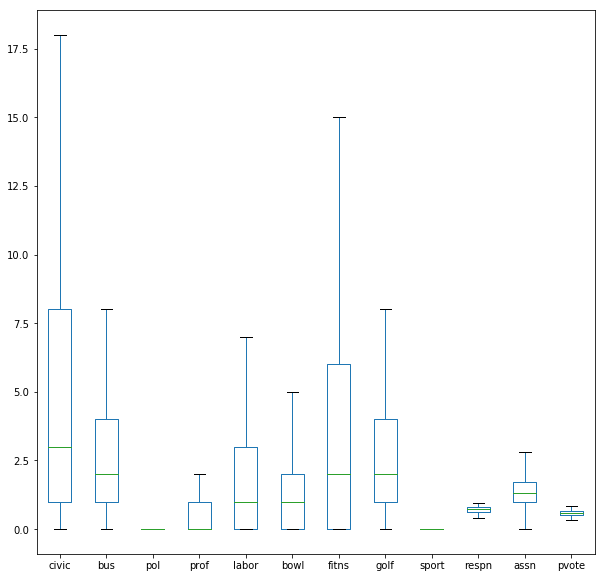

In [4]:
# boxplot most of the 2009 dataset
box2009 = data2009.drop(['relig', 'pop', 'nccs'], axis=1).plot.box(grid=False, figsize=(10,10), showfliers=False)

The plots below show the variance in a bit of a different manner, but more importantly, it shows that for the most part, the feature values remain within a set range, with a few outliers.

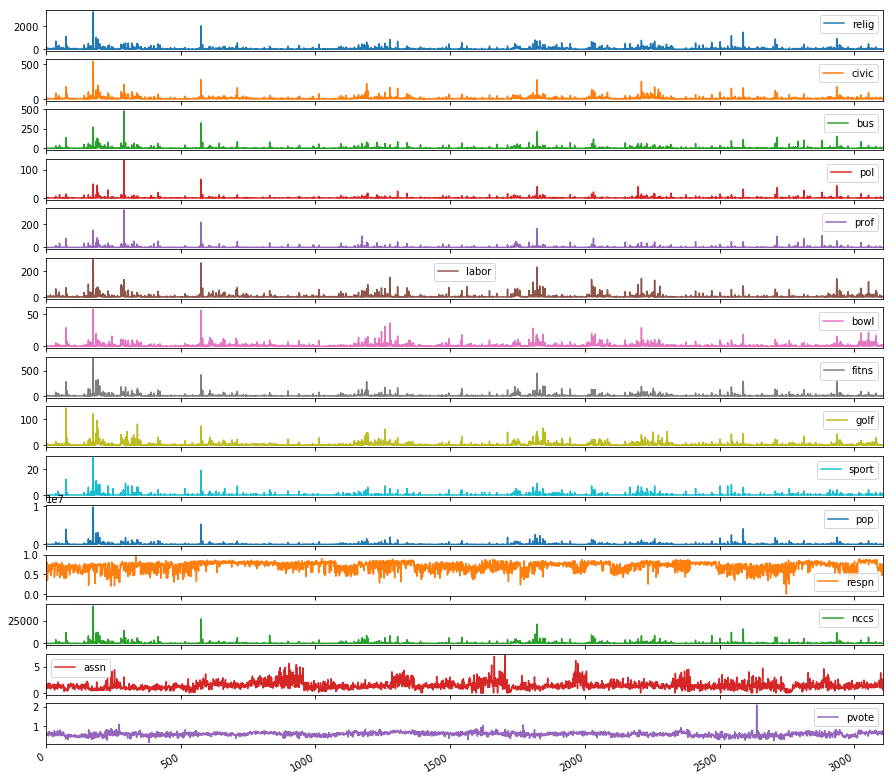

In [5]:
plot2009 = data2009.plot(figsize=(15, 15), subplots=True)

The scatter matrix below displays the relatedness of our four most important features: RESPN, NCCS, ASSN, and PVOTE. As can be seen, the different features on display share varying degrees of relatedness, as some features are very tightly plotted together, while others show a wider spread

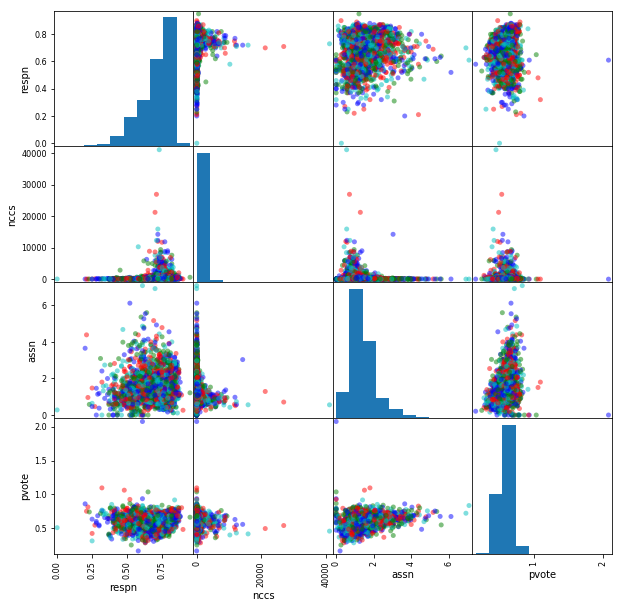

In [6]:
my_colors = ['g', 'b', 'r', 'c']
scatter = pd.plotting.scatter_matrix(data2009.iloc[:, 11:15], diagonal='hist', figsize=(10,10), color=my_colors, s=100)

Here we will perform Principal Component Analysis (PCA) on the 2009 dataset. The resulting plot displays our first two principal components. Upon observing the graph, one can see that the first principal component is possibly affected by an outlying value.

[  9.99999978e-01   1.72122874e-08   2.46591185e-09]


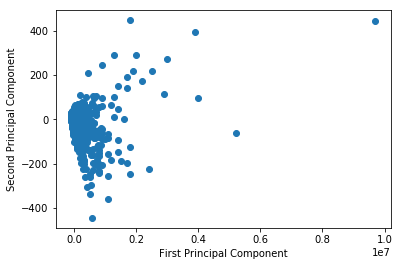

In [7]:
from sklearn import decomposition
# Projection onto the first 2 principal components.

Xpca = X2009.iloc[:, :-3]

# Global centering.
data_centered = Xpca - Xpca.mean()
    
pca = decomposition.PCA(n_components=3)
data_pca = pca.fit_transform(data_centered.dropna())

print(pca.explained_variance_ratio_)

# Plot the data according to the first two principal components.
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Next, we will finally perform Linear Regression to predict what the 2014 voter turnout should be based upon the 2009 data. The idea here is to show that the cultural factors of the 2009 data will be a good training set to predict turnout for the 2014 data.

In [21]:
regr = LinearRegression()

# train data on 2009 data set
regr.fit(X2009.iloc[:, :-4], y2009)

# predict on 2014 data
y_pred = regr.predict(X2014.iloc[:, :-4])

print (y_pred)
print('\n' + 'Coefficients for Regression:')
regr.coef_

[ 0.58261105  0.55585861  0.58411642 ...,  0.59436216  0.59463991
  0.58896524]

Coefficients for Regression:


array([ -3.07895147e-04,  -1.69514927e-05,  -1.16449996e-03,
         1.55854870e-03,   1.56966889e-03,  -2.09436123e-04,
         7.99164196e-03,   2.03150993e-04,   1.65445904e-03,
         2.91157438e-03])

In [9]:
# display the mean squred error
print(np.average((y2014 - y_pred) ** 2))

0.0146643368434


In [10]:
# convert result to list
y2014 = y2014.tolist()

While our overall mean squared error was very low, we want to see which counties did a poor job of being predicted upon. As a result, we have selected a threshold of 0.3 error, and we're looking to find all of the counties that were off by that much. We can then try and explain these differences in poor prediction based on cultural/policy changes in those specific counties.

In [11]:
largestDiffs = [] # list of the counties that exceed our decided threshold
threshold = 0.3
count = 0
# loop through real and predicted values
# pick out indices that exceed threshold of .45 between real and predicted values
for i in range(len(y2014)):
    real = y2014[i]
    pred = y_pred[i]
    if real + threshold < pred or real - threshold > pred:
        largestDiffs.append(count)
    count = count + 1
    
print (len(largestDiffs))
print(largestDiffs)

# print data for each of the found counties that exceeded our threshold
for i in largestDiffs:
    print(data2014.iloc[i, :])

26
[175, 1364, 2206, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105]
relig    3.275000e+03
civic    5.460000e+02
bus      2.830000e+02
pol      7.600000e+01
prof     1.350000e+02
labor    2.830000e+02
bowl     4.600000e+01
fitns    8.450000e+02
golf     1.140000e+02
sport    3.700000e+01
pop      1.010944e+07
respn    5.578946e-01
nccs     7.300000e-01
assn     3.754700e+04
pvote    6.685109e-01
Name: 204, dtype: float64
relig       25.000000
civic        1.000000
bus          3.000000
pol          0.000000
prof         0.000000
labor        0.000000
bowl         0.000000
fitns        0.000000
golf         2.000000
sport        0.000000
pop      10033.000000
respn        3.089804
nccs         0.820000
assn       106.000000
pvote        0.912062
Name: 1399, dtype: float64
relig       0.00000
civic       0.00000
bus         0.00000
pol         0.00000
prof        0.00000
labor       0.00000
bowl    

In addition to our results from Linear Regression, we are curious to see what a K-means Clustering model would do on the same 2009 data. To do this, we while choose many k's, and then observe which k best clusters our data. The idea here is to use the 3 cultural aggregates: respn, nccs, and assn, to put each of the counties into a specific cluster.

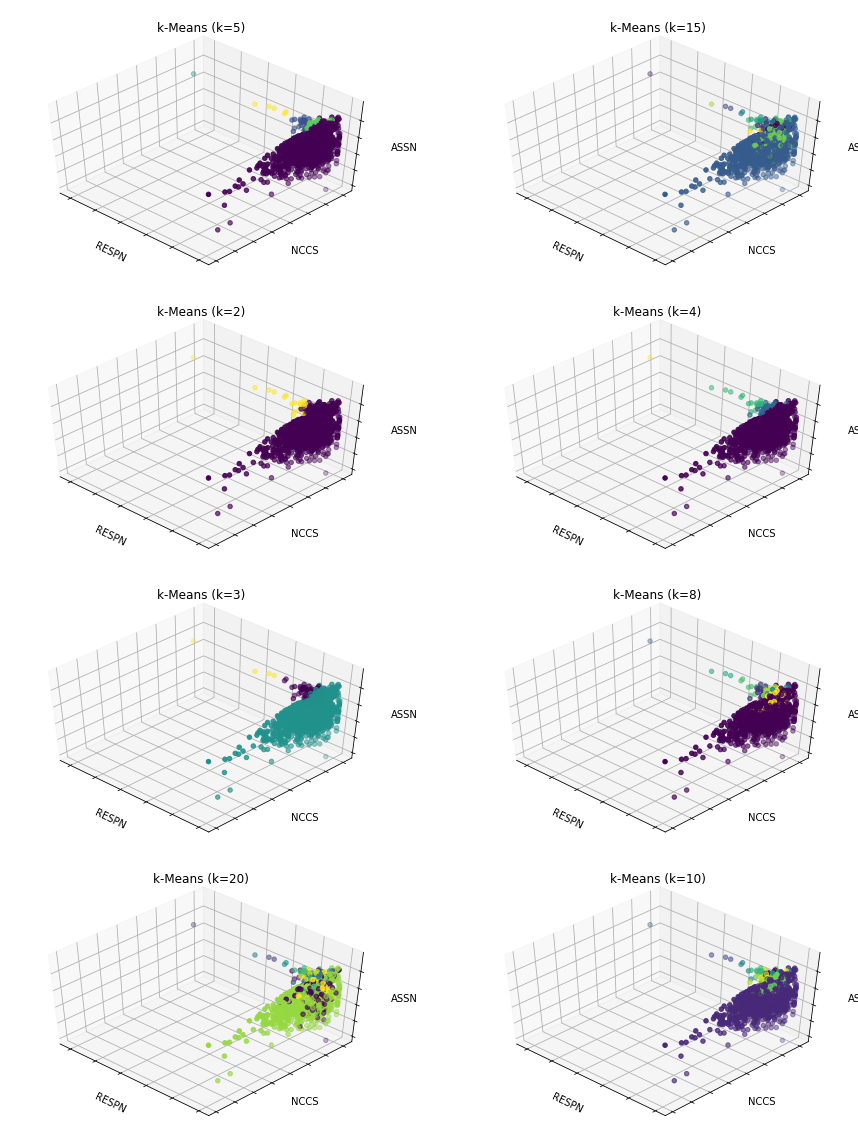

In [43]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# cluster based on last 4 columns
X = X2014.iloc[:, -4:]

# get rid of any possible outlying values in ASSN
index = 0
for assn in X.iloc[:, 2].tolist():
    if assn > 3:
        X.drop(index, axis=0)
        break
    index = index + 1

# Define a set of k-means estimators.
estimators = {'k-Means (k=2)': KMeans(n_clusters=2),
              'k-Means (k=3)': KMeans(n_clusters=3),
              'k-Means (k=4)': KMeans(n_clusters=4),
              'k-Means (k=5)': KMeans(n_clusters=5),
              'k-Means (k=8)': KMeans(n_clusters=8),
              'k-Means (k=10)': KMeans(n_clusters=10),
              'k-Means (k=15)': KMeans(n_clusters=15),
              'k-Means (k=20)': KMeans(n_clusters=20)}

# Define a matplotlib figure.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

labelEval = [] # label to be used in evaluation (k=10)
fignum = 1
for name, est in estimators.items():
    ax = plt.subplot(4, 2, fignum, projection='3d', elev=48, azim=134)

    # Fit the estimator.
    est.fit(X)
    labels = est.labels_
    if name == 'k-Means (k=10)': # to be used in evaluation
        labelEval = labels
    
    # Define a scatterplot.
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=labels.astype(np.float))

    # Customize the plot.
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('RESPN')
    ax.set_ylabel('NCCS')
    ax.set_zlabel('ASSN')
    plt.title("\n" + name + "\n")
    fignum = fignum + 1

Above, we used cultural factors, that did not include voter turnout, to predict the groups into clusters, and then we displayed those predicted clusters. Now, we will take the turnout data for every county, and bin the turnouts into 10 bins, and use those bins as classes. Essentially, if those class based clusters below look similar to the clusters that were created based off of the cultural factors, then we know that you can classify counties by their culture, and that those classifications are nearly the same as if you classify them based on their turnout level.

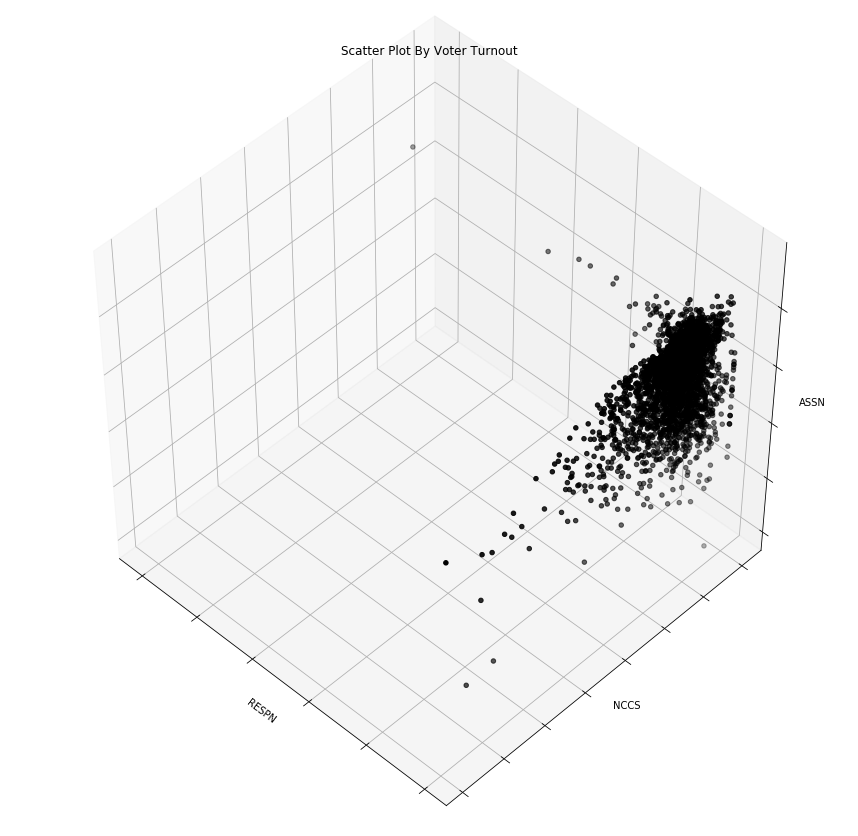

In [27]:
# isolate PVOTE column
Xvt = y2014

# bin the voter turnout
numbins = 10
bins = pd.qcut(Xvt, numbins, retbins=True)[1]

# define color scale based upon bins
color = [str(item/255) for item in bins]
cm = plt.cm.get_cmap('RdYlBu')

# Define a matplotlib figure.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

fignum = 1
ax = plt.subplot(1, 1, fignum, projection='3d', elev=48, azim=134)

# Define a scatterplot.
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=color, cmap=cm)

# Customize the plot.
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('RESPN')
ax.set_ylabel('NCCS')
ax.set_zlabel('ASSN')
plt.title("\n" + 'Scatter Plot By Voter Turnout' + "\n")

Next, we will use KNN to show numerically how accurate our clustering produced by K-means is, as compared to the ground truth provided by the PVOTE clustering.

In [45]:
# create 1-KNN classifer
clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn.fit(labelEval, y2014)

C:\Users\Stephen\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 3106]

In [56]:
# test our clusters using several scores
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print(adjusted_rand_score(labels_true=y2014, labels_pred=labelEval))
print(completeness_score(labels_true=y2014, labels_pred=labelEval))
print(homogeneity_score(labels_true=y2014, labels_pred=labelEval))
print(v_measure_score(labels_true=y2014, labels_pred=labelEval))

2.66602009642e-07
1.0
0.104237556278
0.188795528073


As you can see above, the turnout based classification yields very similar results to the cultural based clustering, which shows that there is a clear correlation between them. To show this further, we test the the statistical signifcance of each of our three core cultural components: RESPN, NCCS, and ASSN, with regard to voter turnout.

In [14]:
from scipy.stats import pearsonr
print('Evaluation for Statistical Significance:')
print('RESPN-PVOTE:')
print(pearsonr(data2009['respn'],data2009['pvote']))
print('NCCS-PVOTE:')
print(pearsonr(data2009['nccs'],data2009['pvote'])) 
print('ASSN-PVOTE:')
print(pearsonr(data2009['assn'],data2009['pvote']))
# definitely significant, and this is aggregate of the other big variables, so this makes a ton of sense

Evaluation for Statistical Significance:
RESPN-PVOTE:
(0.055351797338084388, 0.0020289418867297246)
NCCS-PVOTE:
(-0.020771282748022694, 0.2471605931099338)
ASSN-PVOTE:
(0.26067096067368578, 2.0327301463420969e-49)


From these significance tests, we can see that ASSN is statistically significant with a p value of 2e-49 and that RESPN is also significant, with a p value of .002. These correlations make sense when looking at the data set. RESPN is a means of measuring response rates to the census, which one would expect to be an indicator of turnout as well. ASSN is an aggregation of all of the cultural factors of the social capital index, such as number of community organizations and sports clubs. So if the social capital theory is sound, it also makes sense that this is significant. While NCCS is not a significant relationship, mainly because it's a discussion of foreign based non-profit organizations, we include it in our tests because the social capital indexes believe in its importance, and our goal was to test those, not to develop the best means of predicting turnout.